# Import Library

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
from collections import defaultdict
import re
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm

from tqdm.notebook import tqdm as tq # untuk menampilkan bar progress saat iterasi

In [2]:
# library yang berkaitan dengan pengolahan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma

In [3]:
# Library yang berkaitan dengan pembuatan model dan evaluasi model
# Install tensorflow if it's not already installed
!pip install tensorflow

import tensorflow as tf
# Import Keras *after* TensorFlow
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras import Model, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNet, EfficientNetB0, MobileNetV2, ResNet50, VGG16
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # menonaktifkan warning yang mungkin muncul, seperti warning FutureWarning

# Data Loading

In [5]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bangdatu","key":"95a4cc85b69be7841ca3ad0ae87e80d7"}'}

In [6]:
!rm -rf Skin/
# Buat folder .kaggle jika belum ada
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan file ke folder .kaggle
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Ubah izin file agar hanya bisa diakses oleh owner
os.chmod('/root/.kaggle/kaggle.json', 600)

!kaggle datasets download -d subirbiswas19/skin-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/subirbiswas19/skin-disease-dataset
License(s): CC0-1.0
  0% 0.00/17.3M [00:00<?, ?B/s]
100% 17.3M/17.3M [00:00<00:00, 1.26GB/s]


In [7]:
!unzip skin-disease-dataset.zip


Archive:  skin-disease-dataset.zip
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (1).webp  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (104).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (106).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (115).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (119).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (124).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (135).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (139).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (144).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (147).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (148).jpg  
  inflating: skin-di

In [8]:
!kaggle datasets download -d pacificrm/skindiseasedataset

Dataset URL: https://www.kaggle.com/datasets/pacificrm/skindiseasedataset
License(s): CC0-1.0
 99% 1.35G/1.36G [00:05<00:00, 249MB/s]
100% 1.36G/1.36G [00:06<00:00, 242MB/s]


In [9]:
!unzip skindiseasedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-2.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-3.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-1.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-10.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-100.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-101.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-102.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-103.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-104.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-105.jpeg  
  inflating: Ski

# Data Understanding

In [10]:
# Memuat data dan melihat bentuk data
base_path = 'skin-disease-datasaet'
train_dir = os.path.join(base_path, 'train_set')
test_dir = os.path.join(base_path, 'test_set')

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print("Kelas dalam train set:", os.listdir(train_dir))
print("Jumlah kelas:", len(os.listdir(train_dir)))

Train directory: skin-disease-datasaet/train_set
Test directory: skin-disease-datasaet/test_set
Kelas dalam train set: ['FU-nail-fungus', 'BA- cellulitis', 'FU-athlete-foot', 'VI-shingles', 'BA-impetigo', 'VI-chickenpox', 'PA-cutaneous-larva-migrans', 'FU-ringworm']
Jumlah kelas: 8


* Mengorganisasi dataset dalam struktur folder yang umum digunakan untuk klasifikasi gambar, di mana setiap subfolder mewakili satu kelas.
Dengan menampilkan nama-nama kelas dan menghitung jumlahnya, didapatkan:
1. Memastikan apakah semua kelas sudah tersedia.
2. Melihat distribusi awal sebelum melakukan eksplorasi atau visualisasi lebih lanjut.

In [11]:
# Memuat data dan melihat bentuk data
add_on_path = 'SkinDisease/SkinDisease'

os.rename('SkinDisease/SkinDisease/test', 'SkinDisease/SkinDisease/test_set')
os.rename('SkinDisease/SkinDisease/train', 'SkinDisease/SkinDisease/train_set')
train_dir = os.path.join(add_on_path, 'train_set')
test_dir = os.path.join(add_on_path, 'test_set')

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print("Kelas dalam train set:", os.listdir(train_dir))
print("Jumlah kelas:", len(os.listdir(train_dir)))

Train directory: SkinDisease/SkinDisease/train_set
Test directory: SkinDisease/SkinDisease/test_set
Kelas dalam train set: ['Candidiasis', 'SkinCancer', 'Bullous', 'DrugEruption', 'Actinic_Keratosis', 'Vascular_Tumors', 'Acne', 'Moles', 'Tinea', 'Vitiligo', 'Eczema', 'Warts', 'Lichen', 'Infestations_Bites', 'Sun_Sunlight_Damage', 'Vasculitis', 'Rosacea', 'Seborrh_Keratoses', 'Unknown_Normal', 'Benign_tumors', 'Psoriasis', 'Lupus']
Jumlah kelas: 22


Kode di atas bertujuan untuk:
* Mengganti nama folder train dan test menjadi train_set dan test_set.
* Menentukan path ke folder baru tersebut.
* Menampilkan isi dan struktur dataset training.


In [12]:
def transfer_class(src_path, dest_path, class_name):

    # Define test and train splits
    splits = ['test_set', 'train_set']

    for split in splits:
        # Construct source and destination paths for the class
        src_dir = os.path.join(src_path, split, class_name)
        dest_dir = os.path.join(dest_path, split, class_name)

        # Check if source directory exists
        if not os.path.exists(src_dir):
            print(f"Warning: Class '{class_name}' does not exist in {src_path}/{split}. Skipping.")
            continue

        # Create destination directory if it doesn't exist
        os.makedirs(dest_dir, exist_ok=True)

        # Get list of files in source directory
        copied_count = 0
        for file_name in os.listdir(src_dir):
            src_file = os.path.join(src_dir, file_name)
            dest_file = os.path.join(dest_dir, file_name)

            # Skip if file already exists in destination
            if os.path.exists(dest_file):
                print(f"File '{file_name}' already exists in {dest_dir}. Skipping.")
                continue
            shutil.copy2(src_file, dest_file)
            copied_count += 1

        print(f"Copied {copied_count} files from {src_dir} to {dest_dir}.")


1. Fungsi `transfer_class` dibuat untuk **menyalin seluruh file gambar dari satu kelas tertentu** (`class_name`) **di dalam folder `train_set` dan `test_set` dari direktori sumber (`src_path`) ke direktori tujuan (`dest_path`)**, sambil memastikan struktur direktori tetap rapi dan tidak menimpa file yang sudah ada.

2. Fungsi ini digunakan untuk:
* Menyalin gambar secara otomatis berdasarkan kelas dari satu dataset ke dataset lain.
* Menjaga struktur data tetap konsisten (`train_set/class_name/` dan `test_set/class_name/`).
* Melewati file duplikat yang sudah ada di direktori tujuan untuk menghindari overwrite.
* Menampilkan log berapa banyak file yang berhasil disalin.

In [13]:
class_to_transfer=['Eczema','Acne','Impetigo']
for kelas in class_to_transfer:
  transfer_class('/content/SkinDisease/SkinDisease', '/content/skin-disease-datasaet', kelas)

Copied 112 files from /content/SkinDisease/SkinDisease/test_set/Eczema to /content/skin-disease-datasaet/test_set/Eczema.
Copied 1010 files from /content/SkinDisease/SkinDisease/train_set/Eczema to /content/skin-disease-datasaet/train_set/Eczema.
Copied 65 files from /content/SkinDisease/SkinDisease/test_set/Acne to /content/skin-disease-datasaet/test_set/Acne.
Copied 593 files from /content/SkinDisease/SkinDisease/train_set/Acne to /content/skin-disease-datasaet/train_set/Acne.


Kode di atas bertujuan untuk **menyalin data gambar dari tiga kelas tertentu** — `'Eczema'`, `'Acne'`, dan `'Impetigo'` — dari direktori sumber (`/content/SkinDisease/SkinDisease`) ke direktori tujuan (`/content/skin-disease-datasaet`) **untuk subset `train_set` dan `test_set`**.

In [14]:
train_path = "skin-disease-datasaet/train_set"
test_path = "skin-disease-datasaet/test_set"


subdirectories = [f.name for f in os.scandir(train_path) if f.is_dir()]

print("Daftar Kelas:")
for subdir in subdirectories:
    print(f">>> {subdir}")

Daftar Kelas:
>>> FU-nail-fungus
>>> BA- cellulitis
>>> Acne
>>> FU-athlete-foot
>>> VI-shingles
>>> BA-impetigo
>>> VI-chickenpox
>>> Eczema
>>> PA-cutaneous-larva-migrans
>>> FU-ringworm


## Menghitung Jumlah Gambar per Kelas

In [15]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
    class_counts_df = class_counts_df.reset_index().rename(columns={'index': 'class'})


    print("Distribusi Kelas:")
    print(class_counts_df)


    plt.figure(figsize=(10, 6))
    sns.barplot(x='class', y='count', data=class_counts_df)
    plt.title('Jumlah Gambar per Kelas')
    plt.xticks(rotation=45)
    plt.show()



### Distribusi Kelas train

Distribusi Kelas:
                        class  count
0              FU-nail-fungus    129
1              BA- cellulitis    136
2                        Acne    593
3             FU-athlete-foot    124
4                 VI-shingles    130
5                 BA-impetigo     80
6               VI-chickenpox    136
7                      Eczema   1010
8  PA-cutaneous-larva-migrans    100
9                 FU-ringworm     90


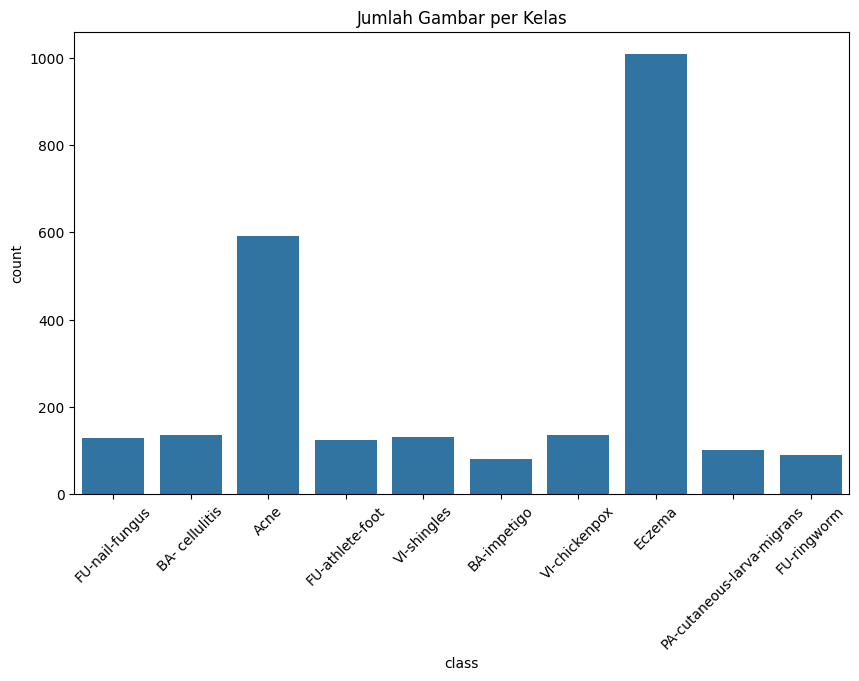

None


In [16]:
print(count_images_per_class(train_path))

### Distribusi Kelas test

Distribusi Kelas:
                        class  count
0              FU-nail-fungus     33
1              BA- cellulitis     34
2                        Acne     65
3             FU-athlete-foot     32
4                 VI-shingles     33
5                 BA-impetigo     20
6               VI-chickenpox     34
7                      Eczema    112
8  PA-cutaneous-larva-migrans     25
9                 FU-ringworm     23


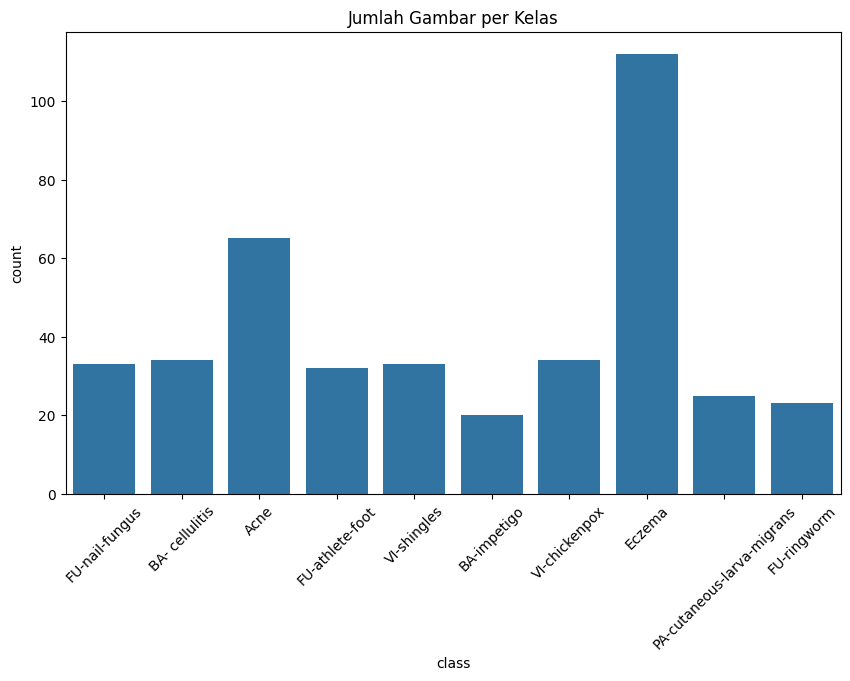

None


In [17]:
print(count_images_per_class(test_path))

Kode ini bertujuan untuk menghitung jumlah gambar pada setiap kelas (folder) di dalam dataset train_set dan test_set, lalu menampilkannya.

## Menampilkan Gambar untuk Semua Kelas

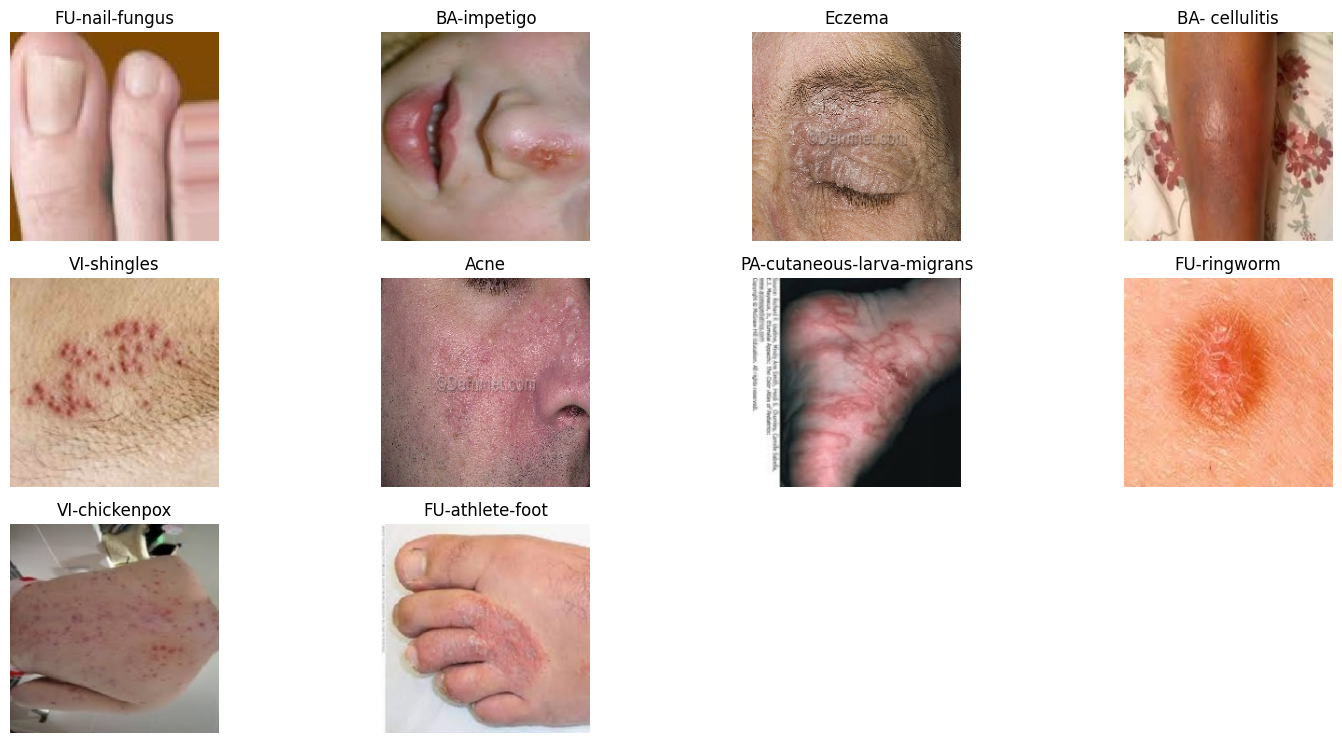

In [ ]:
# Menampilkan gambar untuk semua kelas
def plot_class_images(directory):
    class_names = os.listdir(directory)
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        first_image = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, first_image)
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_images(train_path)

Kode ini digunakan untuk menampilkan contoh gambar pertama dari setiap kelas yang ada dalam folder train_set dalam satu tampilan visual. Dimana fungsi plot_class_images(directory) digunakan untuk:
* Membaca semua nama kelas (subfolder).
* Dari setiap kelas, mengambil gambar pertama.
* Menampilkan gambar tersebut dalam grid menggunakan matplotlib, dengan nama kelas sebagai judul.
* load_img(..., target_size=(224, 224)) memastikan semua gambar berukuran seragam saat ditampilkan.

# Data Preprocessing

## Standarisasi + Data Augmentasi

In [ ]:
# ImageDataGenerator dengan validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% dari data train akan dipakai untuk validasi
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator (80% dari dataset/train)
train_generator = train_datagen.flow_from_directory(
    'skin-disease-datasaet/train_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator (20% dari dataset/train)
valid_generator = train_datagen.flow_from_directory(
    'skin-disease-datasaet/train_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test generator (dari folder test seperti biasa)
test_generator = test_datagen.flow_from_directory(
    'skin-disease-datasaet/test_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes

Found 2024 images belonging to 10 classes.
Found 503 images belonging to 10 classes.
Found 410 images belonging to 10 classes.


Kode ini digunakan untuk mempersiapkan data gambar dari dataset penyakit kulit untuk proses pelatihan model deep learning dengan menggunakan ImageDataGenerator dari Keras.
ImageDataGenerator untuk pelatihan dan validasi:

1. Melakukan augmentasi data (rotasi, pergeseran, zoom, dll.) agar model lebih robust.
  * rescale=1./255 menormalisasi pixel gambar.
  * validation_split=0.2 membagi 20% dari train_set untuk validasi.

2. Train Generator (subset='training'):
  * Mengambil 80% data dari train_set.
  * Digunakan untuk melatih model.

3. Validation Generator (subset='validation'):
  * Mengambil 20% data dari train_set.
  * Digunakan untuk mengevaluasi performa model saat pelatihan.

4. Test Generator:
  * Memuat gambar dari test_set tanpa augmentasi.
  * Digunakan untuk evaluasi akhir model.

5. num_classes:
  * Menyimpan jumlah kelas yang dikenali oleh train_generator.

## Menampilkan gambar dari 1 batch data generator

In [ ]:
# menampilkan jumlah batch pada data train
print(f"Jumlah batch (training): {len(train_generator)}")

# mengambil batch 1 data train
batch_1_train = train_generator[0]

# setiap batch tersimpan dalam bentuk tupple
# elemen pertama menyimpan data piksel dari 32 gambar pada batch 1
batch_1_train_data = train_generator[0][0]

# elemen kedua  menyimpan data label dari 32 gambar pada batch 1
batch_1_train_label = train_generator[0][1]

# ukuran batch = 32 (sesuai pengaturan)
print(f"Jumlah gambar pada batch 1: {len(batch_1_train_data)}")
print(f"Jumlah label pada batch 1: {len(batch_1_train_label)}")

# mengambil gambar 1 pada batch 1 data training
image_1_batch_1_train_data = train_generator[0][0][0]

# mengambil label (kelas) gambar 1 pada batch 1 data training
image_1_batch_1_train_label = train_generator[0][1][0]

# menampilkan data gambar 1 : (224, 224, 3)
print(f"\nBatch 1 Gambar 1 train (data):\n{image_1_batch_1_train_data}")

# menampilkan data label (kelas) gambar 1 pada batch 1 data training
print(f"\nBatch 1 Gambar 1 train (Label):\n{image_1_batch_1_train_label}")

Jumlah batch (training): 64
Jumlah gambar pada batch 1: 32
Jumlah label pada batch 1: 32

Batch 1 Gambar 1 train (data):
[[[0.7461931  0.57923794 0.5142434 ]
  [0.75525266 0.5974812  0.5370475 ]
  [0.7568628  0.6009709  0.5509995 ]
  ...
  [0.721205   0.5368912  0.46630302]
  [0.72911125 0.5447975  0.47420922]
  [0.71963316 0.5353194  0.46473116]]

 [[0.74322796 0.5752843  0.5093014 ]
  [0.7542643  0.5935276  0.53210557]
  [0.7568628  0.6019593  0.5490227 ]
  ...
  [0.7038856  0.51957184 0.44898358]
  [0.6939411  0.50962734 0.43903917]
  [0.6894233  0.50510955 0.4345213 ]]

 [[0.74087197 0.5713307  0.50496864]
  [0.7532759  0.58957404 0.5271636 ]
  [0.7568628  0.60294765 0.54704595]
  ...
  [0.68242437 0.49811062 0.4275224 ]
  [0.6788251  0.49451137 0.4239231 ]
  [0.6822134  0.49789974 0.42731148]]

 ...

 [[0.74835825 0.5797308  0.51306415]
  [0.7451632  0.5765357  0.50986904]
  [0.7406454  0.5720179  0.50535125]
  ...
  [0.7490196  0.5254902  0.48235297]
  [0.7490196  0.5254902  0.48

Kode ini digunakan untuk mengecek isi data dan label dari batch pertama dataset pelatihan (training), memastikan bentuk dan struktur data sudah sesuai sebelum digunakan dalam proses pelatihan model.
1. len(train_generator)
  * Menampilkan jumlah total batch dalam train_generator.

2. train_generator[0]
  * Mengambil batch pertama (batch ke-0) dari data latih.
  * Terdiri dari 2 elemen: data gambar dan data label.

3. batch_1_train_data & batch_1_train_label
  * Menyimpan 32 gambar dan 32 label dari batch pertama.
  * Ukuran gambar: (224, 224, 3) sesuai pengaturan sebelumnya.

4. image_1_batch_1_train_data
  * Mengambil gambar pertama dari batch 1.

5. image_1_batch_1_train_label
  * Mengambil label dari gambar pertama pada batch 1.

## Preview Gambar dari train_generator

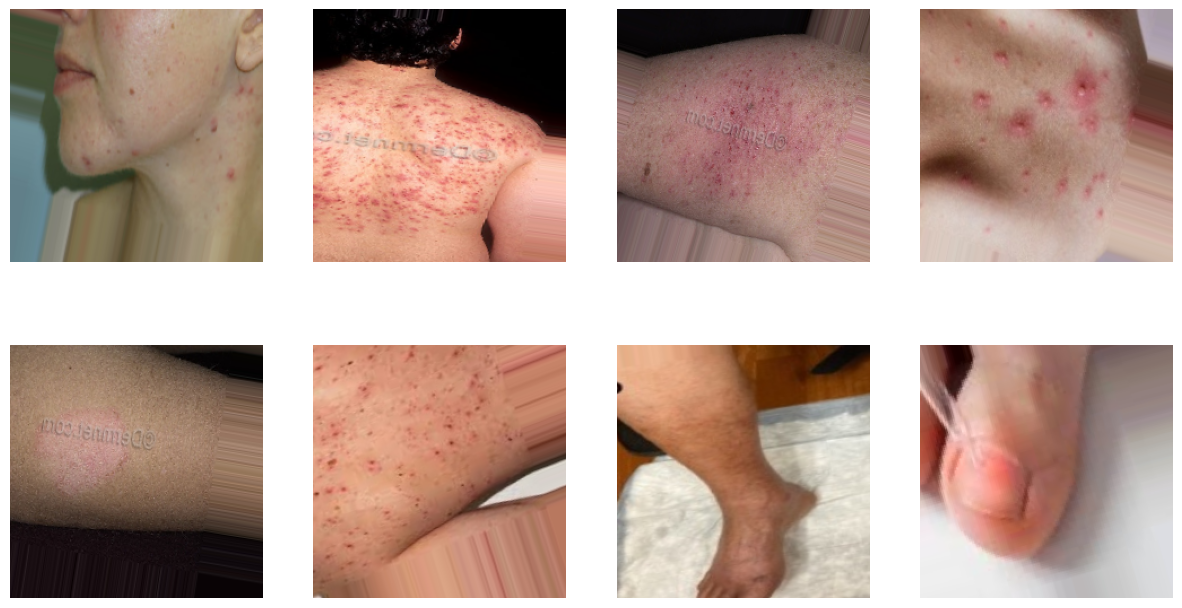

In [ ]:
def show_batch(generator):
    images, labels = next(generator)
    plt.figure(figsize=(15, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_batch(train_generator)

Kode ini bertujuan untuk menampilkan cuplikan (preview) 8 gambar dari satu batch data pelatihan yang dihasilkan oleh train_generator.

# Modeling (Using Transfer Learning MobileNetV2)

In [ ]:
num_classes = train_generator.num_classes


# Load base model tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model (awal)
base_model.trainable = False

# Tambahkan custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Kode ini bertujuan untuk membangun dan meng-compile model klasifikasi citra berbasis arsitektur MobileNetV2 dengan custom classification head sesuai jumlah kelas (num_classes) pada data penyakit kulit.

1. num_classes = train_generator.num_classes
  * Menyimpan jumlah kelas yang akan diprediksi oleh model.

2. MobileNetV2(...)
  * Memuat model MobileNetV2 tanpa top layer (layer klasifikasi) dan dengan bobot pre-trained dari ImageNet. MobileNetV2 dipilih karena merupakan model yang efisien dan ringan, sehingga cocok digunakan pada website real-time yang diakses melalui perangkat dengan spesifikasi rendah seperti ponsel.

3. base_model.trainable = False
  * Membekukan bobot MobileNetV2 agar tidak dilatih (fine-tuning belum dilakukan).

4. Custom head:
  * GlobalAveragePooling2D(): Meratakan output dari feature map jadi vektor 1D.
  * Dropout(0.3): Mengurangi overfitting.
  * Dense(num_classes, activation='softmax'): Layer klasifikasi akhir sesuai jumlah kelas.

5. Model(...)
  * Menggabungkan base_model dan custom head menjadi satu model utuh.

6. model.compile(...)
  * Menyiapkan model untuk training dengan:
    * Optimizer: Adam (learning_rate=1e-4)
    * Loss function: Categorical Crossentropy
    * Metrik evaluasi: Akurasi

## Compile & Train Model

In [ ]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 621ms/step - accuracy: 0.1666 - loss: 2.6478 - val_accuracy: 0.3897 - val_loss: 1.7043
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.3581 - loss: 1.8723 - val_accuracy: 0.4155 - val_loss: 1.5396
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 450ms/step - accuracy: 0.4353 - loss: 1.6693 - val_accuracy: 0.4751 - val_loss: 1.3835
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.5071 - loss: 1.4400 - val_accuracy: 0.5348 - val_loss: 1.2592
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.5484 - loss: 1.3070 - val_accuracy: 0.5646 - val_loss: 1.1868
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.5946 - loss: 1.2224 - val_accuracy: 0.6004 - val_loss: 1.0843
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.6323 - loss: 1.1119 - val_accuracy: 0.6103 - val_loss: 1.0783
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 452ms/step - accuracy: 0.6694 - loss: 1.0236 - val_accu

Kode ini melatih model sambil memantau kinerja validasi, dan menghentikan training lebih awal menggunakan mekanisme penghentian dini (EarlyStopping) jika model mulai overfitting, serta menyimpan bobot terbaik secara otomatis.
1. EarlyStopping(patience=5, restore_best_weights=True)
  * Menghentikan pelatihan secara otomatis jika performa model di data validasi tidak membaik selama 5 epoch berturut-turut.
  * restore_best_weights=True: model akan mengembalikan bobot terbaik sebelum performa mulai menurun.

2. model.fit(...)
  * Memulai proses pelatihan model dengan:
    * Data training: train_generator
    * Data validasi: valid_generator
    * Jumlah epoch maksimum: 20
    * Callback: early_stop untuk menghentikan training lebih awal jika tidak ada peningkatan validasi

## Fine-Tuning (unfreeze sebagian layer MobileNetV2)

In [ ]:
# Unfreeze beberapa layer terakhir
base_model.trainable = True

# Freeze sebagian besar, fine-tune sebagian
for layer in base_model.layers[:-30]:  # hanya fine-tune 30 layer terakhir
    layer.trainable = False

# Recompile model dengan learning rate lebih kecil
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training ulang (fine-tuning)
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 601ms/step - accuracy: 0.6495 - loss: 1.0820 - val_accuracy: 0.7217 - val_loss: 0.7498
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.7407 - loss: 0.8257 - val_accuracy: 0.7276 - val_loss: 0.7679
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - accuracy: 0.7646 - loss: 0.7761 - val_accuracy: 0.7475 - val_loss: 0.7239
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.7922 - loss: 0.6512 - val_accuracy: 0.7356 - val_loss: 0.7369
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 450ms/step - accuracy: 0.8011 - loss: 0.6031 - val_accuracy: 0.7435 - val_loss: 0.7144
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.8348 - loss: 0.5199 - val_accuracy: 0.7256 - val_loss: 0.7090
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 461ms/step - accuracy: 0.8241 - loss: 0.5235 - val_accuracy: 0.7555 - val_loss: 0.6653
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.8651 - loss: 0.4425 - val_accu

Kode ini bertujuan untuk meningkatkan akurasi model melalui fine-tuning sebagian layer terakhir dari model pretrained, dengan pelatihan yang lebih hati-hati (learning rate kecil) dan memantau performa validasi.
1. base_model.trainable = True
  * Membuka semua layer base_model agar bisa dilatih ulang.

2. for layer in base_model.layers[:-30]: layer.trainable = False
  * Membekukan semua layer kecuali 30 layer terakhir, hanya layer akhir yang akan di-fine-tune (disesuaikan ulang).

3. model.compile(...) dengan learning_rate=1e-5
  * Mengompilasi ulang model dengan learning rate kecil agar proses fine-tuning berjalan stabil dan tidak merusak bobot pretrained.

4. model.fit(...)
  * Melatih ulang model dengan callback EarlyStopping, menggunakan data train_generator dan valid_generator.

## Evaluasi Model: Precision, Recall, F1, AUC, Confusion Matrix

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Classification Report:
                            precision    recall  f1-score   support

                      Acne       0.84      0.74      0.79        65
            BA- cellulitis       0.97      0.91      0.94        33
               BA-impetigo       0.90      0.90      0.90        20
                    Eczema       0.82      0.96      0.89       112
           FU-athlete-foot       0.97      0.88      0.92        32
            FU-nail-fungus       0.97      0.97      0.97        33
               FU-ringworm       0.77      0.74      0.76        23
PA-cutaneous-larva-migrans       0.77      0.80      0.78        25
             VI-chickenpox       0.91      0.94      0.93        34
               VI-shingles       0.92      0.73      0.81        33

                  accuracy                           0.87       410
                 macro avg       0.88      0.86      0.87       410
              weighted avg       0.87      0.87    

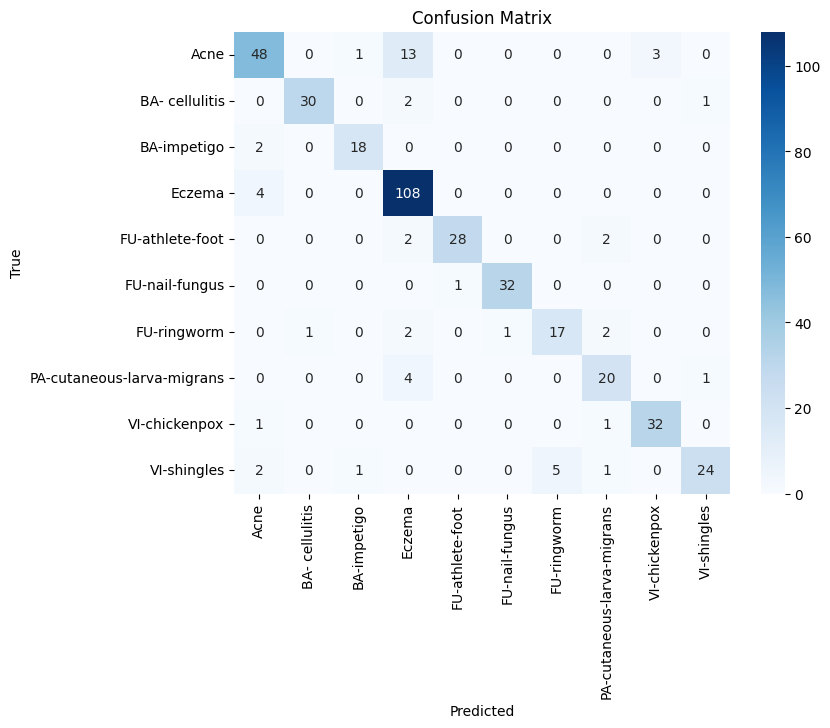

In [ ]:
# Prediksi di test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# AUC Score (multi-class → average='macro')
auc_score = roc_auc_score(tf.keras.utils.to_categorical(y_true, num_classes),
                          y_pred_probs, average='macro')
print(f"AUC-ROC Score: {auc_score:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Output classification report tersebut menunjukkan hasil evaluasi dari model yang digunakan untuk memprediksi 10 kelas penyakit kulit. Ayo kita jelaskan bagian-bagian utamanya:

1. **Metrics per Kelas**

Setiap baris menunjukkan performa untuk satu kelas (penyakit kulit), dengan metrik:
- **Precision**: Dari semua prediksi untuk kelas ini, seberapa banyak yang benar. Tinggi = sedikit false positives.
- **Recall**: Dari semua data aktual untuk kelas ini, seberapa banyak yang berhasil dikenali model. Tinggi = sedikit false negatives.
- **F1-Score**: Harmonik dari precision dan recall. Semakin mendekati 1, makin bagus.
- **Support**: Jumlah sampel sebenarnya untuk kelas tersebut di data uji.

2. **Rata-rata Keseluruhan**
- Accuracy = 0.87. Artinya, 87% dari seluruh prediksi model sudah benar secara keseluruhan.
- Macro avg = rata-rata tanpa mempertimbangkan jumlah data tiap kelas (support).
Cocok untuk melihat apakah model memperlakukan semua kelas secara adil, terutama saat data tidak seimbang.
  * Precision: 0.88
  * Recall: 0.86
  * F1-score: 0.87
- Weighted avg = rata-rata dengan mempertimbangkan support (jumlah data tiap kelas). Lebih mencerminkan performa keseluruhan model ketika dataset tidak seimbang.
  * Semua skor = 0.87

3. **AUC-ROC Score = 0.9921**
- Nilai AUC (Area Under Curve) ini sangat tinggi → model sangat baik dalam membedakan antar kelas.
- Nilai mendekati 1 berarti performa klasifikasi sangat bagus secara umum.

# Inference Menggunakan Gambar dari test_set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


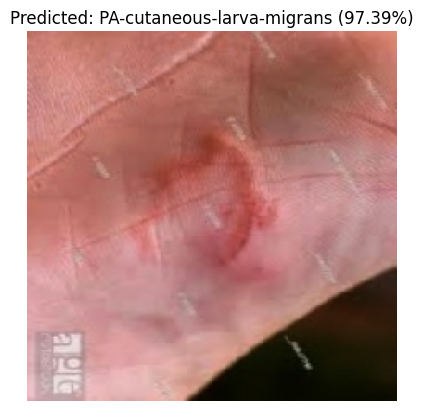

In [ ]:
# Path ke direktori test
test_dir = 'skin-disease-datasaet/test_set'

# Ambil nama kelas
class_names = sorted(os.listdir(test_dir))

# Pilih kelas dan gambar secara acak
selected_class = random.choice(class_names)
img_name = random.choice(os.listdir(os.path.join(test_dir, selected_class)))
img_path = os.path.join(test_dir, selected_class, img_name)

# Preprocessing gambar
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # normalize
img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

# Inference
pred_probs = model.predict(img_array)
pred_class_idx = np.argmax(pred_probs)
pred_class_name = class_names[pred_class_idx]
confidence = np.max(pred_probs) * 100

# Tampilkan hasil
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_class_name} ({confidence:.2f}%)")
plt.show()

Kode ini bertujuan untuk **uji coba prediksi model secara visual pada gambar acak di data test** dengan langkah-langkah sebagai berikut:
* Memilih **secara acak satu gambar** dari folder test berdasarkan kelasnya.
* Melakukan **preprocessing** pada gambar tersebut agar sesuai dengan input model (resize, normalisasi, dan tambah dimensi batch).
* Melakukan **prediksi kelas gambar** menggunakan model yang sudah dilatih.
* Menampilkan gambar beserta **hasil prediksi kelas** dan tingkat keyakinan (confidence) prediksi model dalam bentuk visual.

In [ ]:
model.save('skin_disease_model.h5')

menyimpan model machine learning dalam format HDF5 (.h5) yang sudah dilatih ke dalam file, agar bisa digunakan kembali nanti tanpa perlu melatih ulang.

In [ ]:
model.save('skin_disease_model.keras', save_format='keras')

menyimpan model machine learning dalam  format Keras terbaru (.keras) yang sudah dilatih ke dalam file, agar bisa digunakan kembali nanti tanpa perlu melatih ulang.